# Antibody binding (or escape) to homologs.
This Python Jupyter notebook sees how well each antibody / sera binds to the homologs in the libraries.

## Set up analysis
Import Python modules:

In [1]:
import math
import os

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read escape profiles config, which tells which sets to make plots for:

In [3]:
with open(config['escape_profiles_config']) as f:
    escape_profiles_config = yaml.safe_load(f)

Create output directory:

In [4]:
os.makedirs(config['homologs_dir'], exist_ok=True)

Read homolog escape fractions:

In [5]:
print(f"Reading homolog escape fractions from {config['escape_fracs_homologs']}")
escape_fracs = (
    pd.read_csv(config['escape_fracs_homologs'])
    .query('library == "average"')
    .drop(columns=['library', 'nlibs'])
    .rename(columns={'selection': 'condition'})
    .assign(homolog=lambda x: x['homolog'].map(lambda h: 'SARS-CoV-1' if h == 'SARS-CoV' else h))
    .assign(homolog=lambda x: pd.Categorical(x['homolog'], x['homolog'].unique(), ordered=True))
    )

Reading homolog escape fractions from results/escape_scores/escape_fracs_homologs.csv


## Escape from homologs for all antibodies / sera
Plot how well each homolg escapes each antibody or sera:

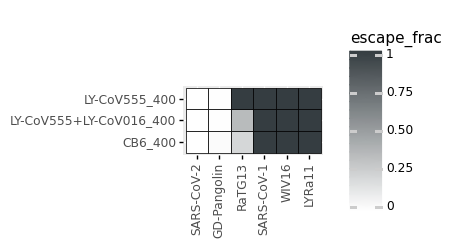

In [6]:
p = (ggplot(escape_fracs) +
     aes('homolog', 'condition', fill='escape_frac') +
     geom_tile(color='black', size=0.3) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.3 * escape_fracs['homolog'].nunique(), 0.3 * escape_fracs['condition'].nunique()),
           ) +
     xlab('') +
     ylab('') +
     scale_fill_gradient(low='white', high='#353D41', limits=(0, 1))
     )
_ = p.draw()

## Escape on specified antibody / sera subsets
We perform analyses on all subsets in the escape profiles config:


Analyzing homolog escape for LY_cocktail, saving plot to results/homologs/LY_cocktail_homolog_escape.pdf


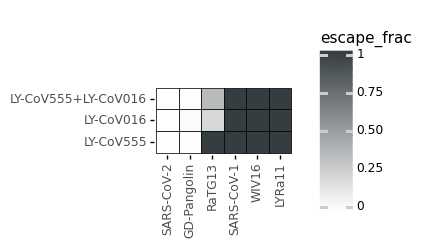

In [7]:
for name, specs in escape_profiles_config.items():

    plotfile = os.path.join(config['homologs_dir'], f"{name}_homolog_escape.pdf")
    print(f"\nAnalyzing homolog escape for {name}, saving plot to {plotfile}")
    
    conditions = specs['conditions']
    
    # get count for conditions of interest for this subset
    df = (escape_fracs
          .query('condition in @conditions')
          .assign(condition=lambda x: x['condition'].map(conditions))
          .assign(condition=lambda x: pd.Categorical(x['condition'], list(conditions.values()), ordered=True))
          )
    
    if len(df) == 0:
        raise RuntimeError(f"no homolog data for {name}")
        
    p = (ggplot(df) +
         aes('homolog', 'condition', fill='escape_frac') +
         geom_tile(color='black', size=0.3) +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(0.3 * df['homolog'].nunique(), 0.3 * df['condition'].nunique()),
               panel_background=element_blank(),
           ) +
         xlab('') +
         ylab('') +
         scale_fill_gradient(low='white', high='#353D41', limits=(0, 1))
         )
    p.save(plotfile, verbose=False)
    fig = p.draw()
    display(fig)
    plt.close(fig)